In [1]:
%matplotlib inline
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from vgg16 import vgg16
from dataLoader import *

### Data download
  - 다운로드 제대로 된 후에는 다시 실행할 필요 없습니다 :)

In [2]:
if not os.path.exists('resource/vgg16_weights.npz'):
    # download images
    os.system('wget cvlab.postech.ac.kr/~jonghwan/224x224_mscoco_images.tar.gz')
    os.system('tar xvzf 224x224_mscoco_images.tar.gz')
    os.system('rm 224x224_mscoco_images.tar.gz')
    os.system('mv 224x224_mscoco_images resource/224x224_mscoco_images')

    # download vgg16 network
    os.system('wget cvlab.postech.ac.kr/~jonghwan/vgg16_weights.npz')
    os.system('mv vgg16_weights.npz resource/vgg16_weights.npz')

### Captioning Network Definition

In [3]:
class Caption_Generator():
    def init_weight(self, dim_in, dim_out, name=None, stddev=1.0):
        return tf.Variable(tf.truncated_normal([dim_in, dim_out], stddev=stddev/math.sqrt(float(dim_in))), name=name)

    def init_bias(self, dim_out, name=None):
        return tf.Variable(tf.zeros([dim_out]), name=name)

    def __init__(self, params, bias_init_vector=None):
        #dim_image, dim_embed, dim_hidden, batch_size, n_lstm_steps, n_words, bias_init_vector=None):
        
        self.wtoi = params['wtoi']
        self.vgg16_weight_file = params['vgg16_weight_file']
        
        # captioning model parameter dimensions
        self.dim_image = np.int(params['dim_image'])
        self.dim_embed = np.int(params['dim_embed'])
        self.dim_hidden = np.int(params['dim_hidden'])
        self.batch_size = np.int(params['batch_size'])
        self.n_lstm_steps = np.int(params['n_lstm_steps'])
        self.n_words = np.int(params['n_words'])
        
        # create model parameters
        self.create_parameters(bias_init_vector)
        
    def create_parameters(self, bias_init_vector):
        # image embedding
        self.encode_img_W = tf.Variable(tf.random_uniform([self.dim_image, self.dim_hidden], \
                                                          -0.01, 0.01), name='encode_img_W')
        self.encode_img_b = self.init_bias(self.dim_hidden, name='encode_img_b')
        
        
        # word embedding
        with tf.device("/cpu:0"):
            self.Wemb = tf.Variable(tf.random_uniform([self.n_words, self.dim_embed], \
                                                      -0.01, 0.01), name='Wemb')
        self.bemb = self.init_bias(self.dim_embed, name='bemb')

        # LSTM cell
        self.lstm = tf.contrib.rnn.BasicLSTMCell(num_units=self.dim_hidden)

        # word prediction
        self.embed_word_W = tf.Variable(tf.random_uniform([self.dim_hidden, self.n_words], \
                                                          -0.01, 0.01), name='embed_word_W')

        if bias_init_vector is not None:
            self.embed_word_b = tf.Variable(bias_init_vector.astype(np.float32), name='embed_word_b')
        else:
            self.embed_word_b = self.init_bias(self.n_words, name='embed_word_b')

    def build_model(self, sess):
        """ Build captioning model for training"""

        image = tf.placeholder(tf.float32, [self.batch_size, 224, 224, 3])
        sentence = tf.placeholder(tf.int32, [self.batch_size, self.n_lstm_steps])
        mask = tf.placeholder(tf.float32, [self.batch_size, self.n_lstm_steps])

        # extract image feature
        vgg = vgg16(image, self.vgg16_weight_file, sess)
        image_feat = vgg.fc7
        
        # embedding image feature to match the dimension of lstm input
        image_emb = tf.matmul(image_feat, self.encode_img_W) + self.encode_img_b # (batch_size, dim_hidden)

        state = self.lstm.zero_state(self.batch_size, tf.float32)

        loss = 0.0
        with tf.variable_scope("LSTM") as lstm_scope:
            for i in range(self.n_lstm_steps):
                if i == 0:
                    # As an initial input for LSTM, we use embedded image feature
                    current_emb = image_emb
                else:
                    # After i=1, we use input words in ground-truth caption
                    with tf.device("/cpu:0"):
                        current_emb = tf.nn.embedding_lookup(self.Wemb, sentence[:,i-1]) + self.bemb

                if i > 0 : 
                    lstm_scope.reuse_variables()
                
                # compute hidden state of lstm
                output, state = self.lstm(current_emb, state) # (batch_size, dim_hidden)

                # At i=0, the predicted word is <S>, so ignore it
                if i > 0: 
                    labels = sentence[:, i]

                    logit_words = tf.matmul(output, self.embed_word_W) + self.embed_word_b # (batch_size, n_words)
                    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit_words, labels=labels)
                    cross_entropy = cross_entropy * mask[:,i]

                    current_loss = tf.reduce_sum(cross_entropy)
                    loss = loss + current_loss

            loss = loss / tf.reduce_sum(mask[:,1:])
            return loss, image, sentence, mask

    def build_generator(self, maxlen, sess):
        """ Build captioning model for test"""
        
        image = tf.placeholder(tf.float32, [self.batch_size, 224, 224, 3])
        
        # extract image feature
        #vgg = vgg16(image, self.vgg16_weight_file, sess)
        vgg = vgg16(image)
        image_feat = vgg.fc7
        
        # embedding image feature to match the dimension of lstm input
        image_emb = tf.matmul(image_feat, self.encode_img_W) + self.encode_img_b

        # set initial state as zero values
        init_state = self.lstm.zero_state(self.batch_size, tf.float32)
        generated_words = []

        with tf.variable_scope("LSTM") as lstm_scope:
            output, prev_state = self.lstm(image_emb, init_state)
            start_word_labels = tf.fill([self.batch_size], int(self.wtoi['<S>']))
            
            with tf.device("/cpu:0"):
                input_word_vectors = tf.nn.embedding_lookup(self.Wemb, start_word_labels) + self.bemb

            for i in range(maxlen):
                lstm_scope.reuse_variables()

                output, prev_state = self.lstm(input_word_vectors, prev_state)

                logit_words = tf.matmul(output, self.embed_word_W) + self.embed_word_b
                max_prob_word = tf.argmax(logit_words, 1)

                # prepare word vector for next time step
                with tf.device("/cpu:0"):
                    input_word_vectors = tf.nn.embedding_lookup(self.Wemb, max_prob_word)
                input_word_vectors += self.bemb

                generated_words.append(max_prob_word)

        return image, image_feat, generated_words

In [4]:
################### Parameters #####################
train_params = {
    'json_path':'resource/train.json',
    'h5py_path':'resource/train.h5',
    'img_dir': 'resource/224x224_mscoco_images/'
}
test_params = {
    'json_path':'resource/test.json',
    'h5py_path':'resource/test.h5',
    'img_dir': 'resource/224x224_mscoco_images/'
}
# create data loader for training and test data
loaders = {}
loaders['train'] = dataLoader(train_params)
loaders['test'] = dataLoader(test_params)

model_params = {
    'wtoi': loaders['train'].getWtoi(),
    'vgg16_weight_file': 'resource/vgg16_weights.npz',
    'dim_image': 4096, # dimension of vgg16 network output
    'dim_embed': 256,
    'dim_hidden': 256,
    'batch_size': 50,
    'n_lstm_steps': loaders['train'].getMaxCaptionLength(),
    'n_words': loaders['train'].getVocabSize(),
}


def train():
    n_epochs = 100
    learning_rate = 0.001
    model_path = './models'
    
    sess = tf.InteractiveSession()
    
    caption_generator = Caption_Generator(model_params)#, bias_init_vector=bias_init_vector)
    loss, image, sentence, mask = caption_generator.build_model(sess)

    saver = tf.train.Saver(max_to_keep=50)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    tf.global_variables_initializer().run()

    iteration_per_epoch = loaders['train'].getNumCaptions() / model_params['batch_size']
    for epoch in range(n_epochs):
        for bi in range(iteration_per_epoch):
            # load batch data
            batch = loaders['train'].getBatch(model_params['batch_size'])

            _, loss_value = sess.run([train_op, loss], feed_dict={image: batch['images'], 
                                                                  sentence : batch['caption_labels'],
                                                                  mask : batch['caption_masks']})

            if bi % 10 == 0:
                print "%d epoch %d iteration Cost: %.4f" % (epoch+1, bi, loss_value)

        print "Epoch ", epoch+1, " is done. Saving the model ... "
        if not os.path.isdir(model_path):
            os.makedirs(model_path)
        saver.save(sess, os.path.join(model_path, 'model'), global_step=epoch)
        learning_rate *= 0.95



In [5]:
def test(model_path='./models/model-0', maxlen=15):
    sess = tf.InteractiveSession()
    
    # create caption generator for test
    model_params['batch_size'] = 1
    caption_generator = Caption_Generator(model_params)
    image, image_feat, output_caption = caption_generator.build_generator(maxlen=maxlen, sess=sess)
    
    # load the model parameters
    saver = tf.train.Saver()
    saver.restore(sess, model_path)

    itow = loaders['test'].getItow()
    predictions = []
    iteration_per_epoch = loaders['test'].getNumCaptions() / model_params['batch_size']
    image_feat_list = []
    for bi in range(10):
        # load batch data
        batch = loaders['test'].getBatch(model_params['batch_size'])
        
        image_feat_calc, generated_word_index = sess.run([image_feat, output_caption], feed_dict={image:batch['images']})
        image_feat_list.append(image_feat_calc)
        generated_word_index = np.hstack(generated_word_index)
        
        generated_words = [ itow[str(x)] for x in generated_word_index]
        punctuation = np.argmax(np.array(generated_words) == '.') + 1

        generated_words = generated_words[:punctuation]
        generated_sentence = ' '.join(generated_words)
        img = np.asarray(batch['images'].reshape(224,224,3)+ np.array([123.68, 116.779, 103.939]).reshape(1,1,3),dtype='uint8')
        I=Image.fromarray(img)
        fig,ax=plt.subplots(1,2)
        ax[1].imshow(I)
        ax[0].plot(image_feat_calc.reshape(-1))
        plt.show()
        
        print('Generated Caption: ', generated_sentence)
        
        ith_prediction = {}
        ith_prediction['image_id'] = batch['image_ids'][0]
        ith_prediction['caption'] = generated_sentence
        predictions.append(ith_prediction)
        
#         if bi == 10:
#             input('Continue to enter:')
        
    # save the prediction outputs
    if not os.path.isdir('result'):
            os.makedirs('result')
    write_json('result/predictions.json', predictions)
    print('Save the predictions to result/predictions.json')

### Training and Testing Model

In [6]:
# test model that means to predict captions for test images
do_train = True
if do_train:
    train()

INFO:tensorflow:Restoring parameters from models/model-70


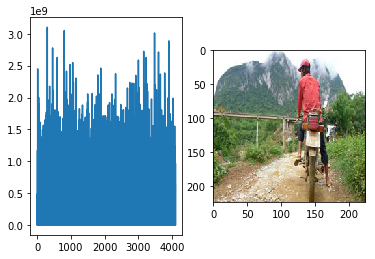

('Generated Caption: ', u'a man is playing a video game in a living room .')


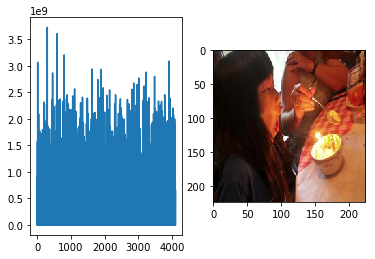

('Generated Caption: ', u'a man is playing a video game in a living room .')


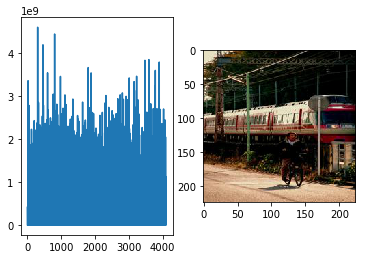

('Generated Caption: ', u'a man is playing a video game in a living room .')


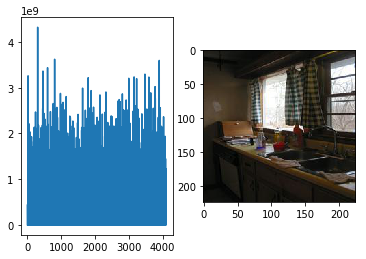

('Generated Caption: ', u'a man is playing a video game in a living room .')


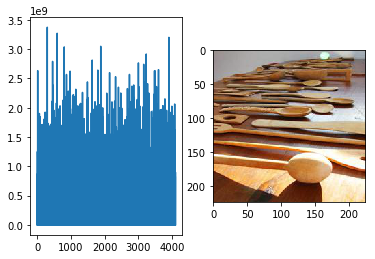

('Generated Caption: ', u'a man is playing a video game in a living room .')


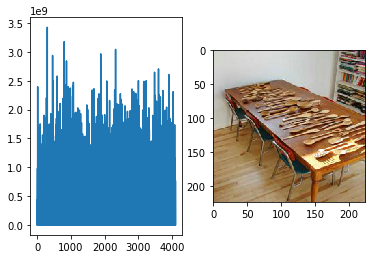

('Generated Caption: ', u'a man is playing a video game in a living room .')


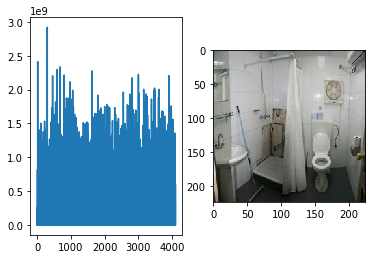

('Generated Caption: ', u'a')


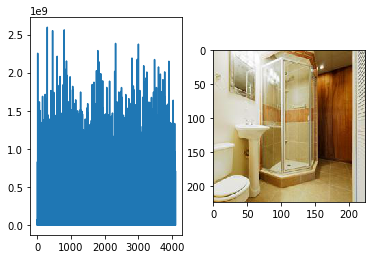

('Generated Caption: ', u'a man in a suit stands in front of a house .')


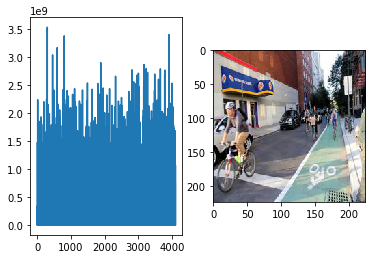

('Generated Caption: ', u'a man is playing a video game in a living room .')


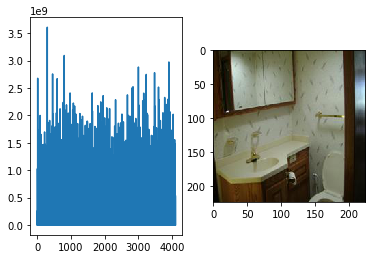

('Generated Caption: ', u'a man is playing a video game in a living room .')
Save the predictions to result/predictions.json


In [7]:
# test model that means to predict captions for test images
test(model_path='models/model-70')

### Evaluation

In [8]:
%matplotlib inline
import sys
sys.path.append('coco-caption')

from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import matplotlib.pyplot as plt
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [9]:
ann_file = 'coco-caption/annotations/captions_val2014.json'
res_file = 'result/predictions.json'

In [10]:
# create coco object and cocoRes object
coco = COCO(ann_file)
cocoRes = coco.loadRes(res_file)

loading annotations into memory...
0:00:00.678125
creating index...
index created!
Loading and preparing results...     
DONE (t=0.03s)
creating index...
index created!


In [11]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
cocoEval.evaluate()

tokenization...
setting up scorers...
computing Bleu score...
{'reflen': 103, 'guess': [100, 90, 81, 72], 'testlen': 100, 'correct': [37, 6, 0, 0]}
ratio: 0.970873786398
Bleu_1: 0.359
Bleu_2: 0.152
Bleu_3: 0.000
Bleu_4: 0.000
computing CIDEr score...
CIDEr: 0.054
